# Comparison of Relative Finding Methods

### Imports

In [1]:
import pandas as pd
import vcf
import os
import subprocess
import numpy as np
import matplotlib.pyplot as plt

# Part 1 - Subpopulations

### Sample List Generation
Here, I generate sample lists by utilizing `igsr_samples.tsv` to gather a list of samples for each subpopulation and storing them in their own respective .txt file in `/samples`. Of all possible subpopulations, `MKK`, `GWF`, `GWW`, and `GWJ` were excluded due to their sample lists being empty when generated.

In [2]:
chr_num = 19
pruned = True
if pruned:
    vcf_file = "../public/1000Genomes/1000G_chr" + str(chr_num) + "_pruned.vcf.gz"
else:
    vcf_file = "../public/1000Genomes/ALL.chr" + str(chr_num) + ".phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz"
    
all_samples = vcf.Reader(filename=vcf_file).samples

In [3]:
df = pd.read_csv("../public/1000Genomes/igsr_samples.tsv", sep='\t')
pop_codes = list(set(df['Population code'].tolist()))
pop_codes = [x for x in pop_codes if len(str(x)) == 3 and not pd.isna(x)]
print(pop_codes)

if "samples" not in os.listdir():
    os.mkdir("samples")
if "samples_singular" not in os.listdir():
    os.mkdir("samples_singular")

for pop in pop_codes:
    subset = df[df['Population code'] == pop]
    subset = subset[subset['Sample name'].isin(all_samples)]
    subset['copy'] = subset['Sample name']
    subset['Sample name'].to_csv('samples_singular/samples_singular_' + pop.lower() + '.txt', sep=' ', header=False, index=False)
    subset[['Sample name', 'copy']].to_csv('samples/samples_' + pop.lower() + '.txt', sep=' ', header=False, index=False)

samples_final = []
for file in os.listdir("samples"):
    if os.path.getsize("samples/" + file) == 0:
        print(file)
        os.remove("samples/" + file)
    elif "ipynb" not in file:
        samples_final.append(file[-7:-4])
        
for file in os.listdir("samples_singular"):
    if os.path.getsize("samples_singular/" + file) == 0:
        print(file)
        os.remove("samples_singular/" + file)

['BEB', 'CLM', 'IBS', 'GWD', 'KHV', 'CHB', 'GWF', 'PUR', 'LWK', 'MSL', 'JPT', 'GWJ', 'MKK', 'FIN', 'TSI', 'ITU', 'GBR', 'ASW', 'STU', 'CEU', 'YRI', 'CHS', 'MXL', 'ACB', 'ESN', 'PEL', 'GWW', 'GIH', 'PJL', 'CDX']
samples_mkk.txt
samples_gwf.txt
samples_gww.txt
samples_gwj.txt
samples_singular_mkk.txt
samples_singular_gwf.txt
samples_singular_gww.txt
samples_singular_gwj.txt


### Defining Measurements of Time and Memory Usage
This function is written to take in a command and run it twice such that both the runtime and the peak memory usage can be measured. These are recorded and then returned by the function. There are three extra optional parameters. Setting `run_time` or `run_mem` to `False` will prevent the function from running that respective measurement. Setting the parameter `printout` to `True` will return the measurements to the user in the form of print statements.

In [4]:
def run_time_mem(command, run_time=True, run_mem=True, printout=False):
    time = 0
    mem = 0
    
    if(run_time):
        proc = subprocess.run("bash -c 'time " + command + "'", shell=True, capture_output=True, text=True)
        time_output = proc.stderr.split()
        #time = float(time_output[-1][2:-1]) + float(time_output[-3][2:-1])
        user = (time_output[-1]).split("m")
        sys = (time_output[-3]).split("m")
        user_time = (int(user[0]) * 60) + float(user[1][:-1])
        sys_time = (int(sys[0]) * 60) + float(sys[1][:-1])
        time = user_time + sys_time
        if(printout):
            print("time: " + str(time))

    if(run_mem):
        proc = subprocess.run("bash -c './memusg " + command + "'", shell=True, capture_output=True, text=True)
        mem_output = proc.stderr.split()
        mem = mem_output[-2]
        if(printout):
            print("mem : " + str(mem))
    
    return [round(time, 3), int(mem)]

### PLINK - Subpopulation Measurements

In [5]:
if "data" not in os.listdir():
    os.mkdir("data")

if pruned:
    os.system("plink --vcf ../public/1000Genomes/1000G_chr" + str(chr_num) + "_pruned.vcf.gz --make-bed --out data/chr_plink")
else:
    os.system("plink --vcf ../public/1000Genomes/ALL.chr" + str(chr_num) + ".phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz --make-bed --out data/chr_plink")

PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/chr_plink.log.
Options in effect:
  --make-bed
  --out data/chr_plink
  --vcf ../public/1000Genomes/1000G_chr19_pruned.vcf.gz

515699 MB RAM detected; reserving 257849 MB for main workspace.
--vcf: data/chr_plink-temporary.bed + data/chr_plink-temporary.bim +
data/chr_plink-temporary.fam written.
17784 variants loaded from .bim file.
2504 people (0 males, 0 females, 2504 ambiguous) loaded from .fam.
Ambiguous sex IDs written to data/chr_plink.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 2504 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 

In [6]:
if "plink" not in os.listdir():
    os.mkdir("plink")

plink_vals = []
for file in os.listdir("samples"):
    if(file[-4:] == ".txt"):
        sample = file[-7:-4]
        print(sample)
        command = "plink --bfile data/chr_plink --keep samples/" + file + " --genome --out plink/" + sample + ".ibd"
        plink_vals.append(run_time_mem(command, printout=True))

print(plink_vals)

khv
time: 0.041999999999999996
mem : 264105564
gbr
time: 0.042
mem : 264105564
acb
time: 0.046
mem : 264105564
ibs
time: 0.051000000000000004
mem : 264105564
chs
time: 0.039
mem : 264105564
ceu
time: 0.046
mem : 264105564
asw
time: 0.027000000000000003
mem : 264105564
msl
time: 0.059000000000000004
mem : 264105564
pel
time: 0.06
mem : 264104536
lwk
time: 0.066
mem : 67156
esn
time: 0.057
mem : 264105564
clm
time: 0.057
mem : 264105564
pur
time: 0.047
mem : 264105564
stu
time: 0.082
mem : 264105564
yri
time: 0.057999999999999996
mem : 264105564
fin
time: 0.062
mem : 264105564
beb
time: 0.057999999999999996
mem : 264105564
cdx
time: 0.063
mem : 264105564
chb
time: 0.066
mem : 264105564
gih
time: 0.053000000000000005
mem : 264105564
itu
time: 0.064
mem : 264105564
gwd
time: 0.067
mem : 264105564
tsi
time: 0.068
mem : 264105564
mxl
time: 0.049
mem : 264105564
jpt
time: 0.045
mem : 264105564
pjl
time: 0.048
mem : 264105564
[[0.042, 264105564], [0.042, 264105564], [0.046, 264105564], [0.051,

### GERMLINE - Subpopulation Measurements

In [7]:
if pruned:
    os.system("bcftools view ../public/1000Genomes/1000G_chr" + str(chr_num) + "_pruned.vcf.gz -O b -o data/chr_plink.bcf")
else:
    os.system("bcftools view ../public/1000Genomes/ALL.chr" + str(chr_num) + ".phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz -O b -o chr_plink.bcf")

if "germline" not in os.listdir():
    os.mkdir("germline")
    
germline_vals = []
for file in os.listdir("samples_singular"):
    if(file[-4:] == ".txt"):
        sample = file[-7:-4]
        print(sample)
        os.system("bcftools view -S samples_singular/" + file + " data/chr_plink.bcf -O b -o data/subset_" + sample + ".bcf")
        os.system("vcftools --bcf data/subset_" + sample + ".bcf --plink --out data/out_sub_" + sample + " >/dev/null 2>&1")
        command = "./germline-1-5-3/bin/germline -input data/out_sub_" + sample + ".ped data/out_sub_" + sample + ".map -output germline/" + sample + ".germ"
        germline_vals.append(run_time_mem(command))

print(germline_vals)

ceu
chs
ibs
gbr
acb
khv
lwk
pel
esn
msl
asw
fin
cdx
beb
stu
pur
yri
clm
pjl
jpt
gwd
tsi
mxl
itu
gih
chb
[[0.244, 38364], [0.27, 38628], [0.305, 39156], [0.236, 38892], [0.235, 38760], [0.255, 38364], [0.272, 38496], [0.271, 38628], [0.271, 38628], [0.238, 38100], [0.177, 37176], [0.256, 38496], [0.267, 38892], [0.22, 37572], [0.266, 38628], [0.277, 38496], [0.269, 38760], [0.238, 38760], [0.249, 38892], [0.313, 38760], [0.28, 39156], [0.275, 38628], [0.178, 37308], [0.259, 39156], [0.302, 38496], [0.256, 38628]]


### IBDseq - Subpopulation Measurements

In [8]:
if "ibdseq" not in os.listdir():
    os.mkdir("ibdseq")

ibdseq_vals = []
for file in os.listdir("samples"):
    if(file[-4:] == ".txt"):
        sample = file[-7:-4]
        print(sample)
        os.system("bcftools view data/subset_" + sample + ".bcf -O v -o data/subset_" + sample + ".vcf")
        
        #-Xmx192706m
        command = "java -jar ibdseq.r1206.jar gt=data/subset_" + sample + ".vcf out=ibdseq/" + sample + ".ibdseq"
        ibdseq_vals.append(run_time_mem(command))

print(ibdseq_vals)

khv
gbr
acb
ibs
chs
ceu
asw
msl
pel
lwk
esn
clm
pur
stu
yri
fin
beb
cdx
chb
gih
itu
gwd
tsi
mxl
jpt
pjl
[[9.968, 3900968], [8.31, 3900968], [11.242, 3900968], [11.469, 3900968], [10.236, 3900968], [10.39, 3900968], [5.709, 3900968], [9.21, 3900968], [7.712, 3900968], [11.028, 3900968], [11.195, 3900968], [9.911, 3900968], [11.004, 3900968], [10.466, 3900968], [13.169, 3900968], [10.092, 3900968], [8.078, 3900968], [8.333, 3900968], [10.172, 3900968], [10.381, 3900968], [10.989, 3900968], [13.708, 3900968], [11.678, 3900968], [5.073, 3900968], [9.835, 3900968], [9.508, 3900968]]


### BEAGLE's fastIBD - Subpopulation Measurements

In [13]:
if "fastibd" not in os.listdir():
    os.mkdir("fastibd")

fastibd_vals = []
for file in os.listdir("samples"):
    if(file[-4:] == ".txt"):
        sample = file[-7:-4]
        print(sample)
        os.system("cat data/subset_" + sample + ".vcf | java -jar vcf2beagle.jar ? data/subset_" + sample)
        
        command = "java -jar beagle.jar unphased=data/subset_" + sample + ".bgl.gz markers=data/subset_" + sample + ".markers fastibd=true out=fastibd/" + sample + ".fastibd missing=?"
        fastibd_vals.append(run_time_mem(command))

print(fastibd_vals)

khv
gbr
acb
ibs
chs
ceu
asw
msl
pel
lwk
esn
clm
pur
stu
yri
fin
beb
cdx
chb
gih
itu
gwd
tsi
mxl
jpt
pjl
[[57.197, 3768464], [53.322, 3768240], [2.845, 3768096], [2.296, 3768096], [58.451, 3768464], [60.727, 3768464], [32.218, 3768096], [55.38, 3768096], [44.248, 3768096], [53.265, 3768096], [4.65, 3768096], [60.855, 3768096], [52.151, 3768096], [46.987, 3768096], [11.468, 3768096], [49.37, 3768464], [41.905, 3768096], [54.45, 3768096], [60.504, 3769892], [4.308, 3768096], [50.962, 3768096], [55.968, 3769892], [48.228, 3768096], [42.769, 3768096], [58.836, 3768096], [58.168, 3768096]]


### Subpopulation Visualizations

In [22]:
persistent_p1 = [plink_vals, germline_vals, ibdseq_vals, fastibd_vals]

with open('persistent_p1.txt', 'w') as file:
    file.write(str(persistent_p1))

In [8]:
with open('persistent_p1.txt', 'r') as file:
    persistent_p1 = eval(file.read())
    
plink_vals = persistent_p1[0]
germline_vals = persistent_p1[1]
ibdseq_vals = persistent_p1[2]
fastibd_vals = persistent_p1[3]

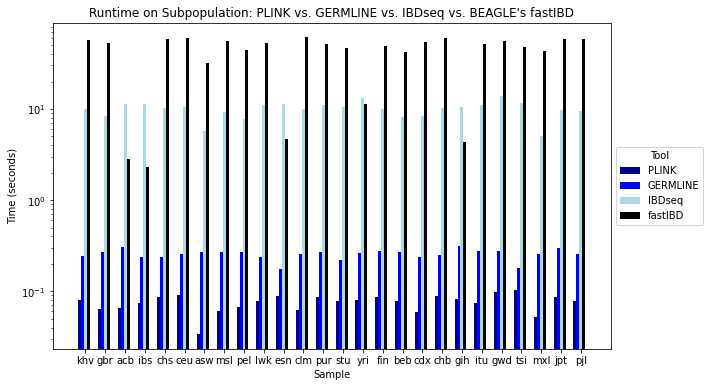

In [9]:
x = np.arange(len(persistent_p1[0]))
y1 = [item[0] for item in plink_vals]
y2 = [item[0] for item in germline_vals]
y3 = [item[0] for item in ibdseq_vals]
y4 = [item[0] for item in fastibd_vals]

plt.figure(figsize=(10, 6))
bar_width = 0.15

plt.bar(x, y1, width=bar_width, label='PLINK', color='darkblue')
plt.bar(x + bar_width, y2, width=bar_width, label='GERMLINE', color='blue')
plt.bar(x + bar_width * 2, y3, width=bar_width, label='IBDseq', color='lightblue')
plt.bar(x + bar_width * 3, y4, width=bar_width, label='fastIBD', color='black')

plt.xlabel('Sample')
plt.ylabel('Time (seconds)')
plt.title('Runtime on Subpopulation: PLINK vs. GERMLINE vs. IBDseq vs. BEAGLE\'s fastIBD')
labels = samples_final
plt.xticks(x + bar_width * 2, labels)
plt.yscale('log')
plt.legend(title = "Tool", loc='center left', bbox_to_anchor=(1, 0.5))

# Part 2 - Stress Testing / Time Complexity

### Subset File Generation
Here, I generate the largest possible set of samples and from it, I create many subsets (in increments of 100) and store them in .txt files in `/sizes`.

In [5]:
if "sizes" not in os.listdir():
    os.mkdir("sizes")
if "total" not in os.listdir("sizes"):
    os.mkdir("sizes/total")
if "total_singular" not in os.listdir("sizes"):
    os.mkdir("sizes/total_singular")
    
with open("sizes/total/total.txt", 'w') as out:
    for file in os.listdir("samples"):
        if(file[-4:] == ".txt"):
            with open("samples/" + file, 'r') as file:
                out.writelines(file.readlines())

with open("sizes/total_singular/total_singular.txt", 'w') as out:                
    for file in os.listdir("samples_singular"):
        if(file[-4:] == ".txt"):
            with open("samples_singular/" + file, 'r') as file:
                out.writelines(file.readlines())

In [6]:
with open("sizes/total/total.txt", 'r') as file:
    all_lines = file.readlines()
    num_lines = len(all_lines)

sizes = range(0, num_lines, 100)
sizes = sizes[1:]
for size in sizes:
    with open("sizes/total/total_" + str(size) + ".txt", 'w') as file:
        file.writelines(all_lines[:size])
        
        
with open("sizes/total_singular/total_singular.txt", 'r') as file:
    all_lines = file.readlines()
    num_lines = len(all_lines)

sizes = range(0, num_lines, 100)
sizes = sizes[1:]
for size in sizes:
    with open("sizes/total_singular/total_singular_" + str(size) + ".txt", 'w') as file:
        file.writelines(all_lines[:size])

In [7]:
if "data" not in os.listdir("sizes"):
    os.mkdir("sizes/data")

### PLINK - Stress Testing

In [5]:
if "ibd" not in os.listdir("sizes"):
    os.mkdir("sizes/ibd")

plink_sizes = []
for file in os.listdir("sizes/total"):
    if "total_" in file:
        curr = file[:-4]
        print(curr)
        command = "plink --bfile data/chr_plink --keep sizes/total/" + file + " --genome --out sizes/ibd/" + curr + ".ibd"
        times = run_time_mem(command)
        
        plink_sizes.append([int(curr[6:]),times])

total_2100
total_1600
total_300
total_2000
total_200
total_1700
total_2300
total_1400
total_100
total_1800
total_2200
total_1500
total_1900
total_2500
total_700
total_1200
total_2400
total_1300
total_600
total_900
total_500
total_1000
total_800
total_1100
total_400


### PLINK - Individual Analysis

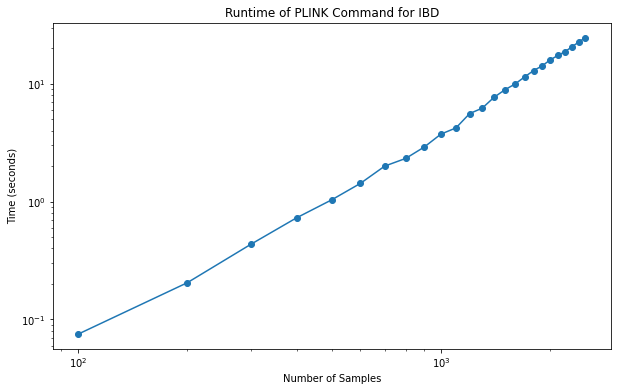

In [25]:
plink_sizes_sorted = sorted(plink_sizes, key = lambda x : x[0])
x = [item[0] for item in plink_sizes_sorted]
y = [item[1][0] for item in plink_sizes_sorted]

plt.figure(figsize=(10, 6))
plt.plot(x, y, marker = 'o')

plt.xlabel("Number of Samples")
plt.ylabel("Time (seconds)")
plt.title("Runtime of PLINK Command for IBD")
plt.xscale('log')
plt.yscale('log')

### GERMLINE - Stress Testing

In [9]:
if "germline" not in os.listdir("sizes"):
    os.mkdir("sizes/germline")

germline_sizes = []
for file in os.listdir("sizes/total_singular"):
    if "total_singular_" in file:
        curr = file[:-4]
        print(curr)
        os.system("bcftools view -S sizes/total_singular/" + file + " data/chr_plink.bcf -O b -o sizes/data/" + curr + ".bcf")
        os.system("vcftools --bcf sizes/data/" + curr + ".bcf --plink --out sizes/data/out_sub_" + curr + " >/dev/null 2>&1")
        command = "./germline-1-5-3/bin/germline -input sizes/data/out_sub_" + curr + ".ped sizes/data/out_sub_" + curr + ".map -output sizes/germline/" + curr + ".germ"
        times = run_time_mem(command)
        
        germline_sizes.append([int(curr[15:]),times])

total_singular_1200
total_singular_700
total_singular_2500
total_singular_600
total_singular_1300
total_singular_2400
total_singular_900
total_singular_500
total_singular_1000
total_singular_800
total_singular_1100
total_singular_400
total_singular_300
total_singular_1600
total_singular_2100
total_singular_1700
total_singular_200
total_singular_2000
total_singular_1400
total_singular_100
total_singular_1800
total_singular_2300
total_singular_1500
total_singular_1900
total_singular_2200


### GERMLINE - Individual Analysis

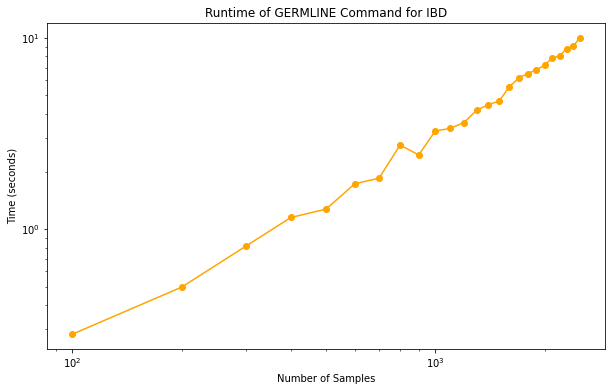

In [24]:
germline_sizes_sorted = sorted(germline_sizes, key = lambda x : x[0])
x2 = [item[0] for item in germline_sizes_sorted]
y2 = [item[1][0] for item in germline_sizes_sorted]

plt.figure(figsize=(10, 6))
plt.plot(x2, y2, marker = 'o', color="orange")

plt.xlabel("Number of Samples")
plt.ylabel("Time (seconds)")
plt.title("Runtime of GERMLINE Command for IBD")
plt.xscale('log')
plt.yscale('log')

### IBDseq - Stress Testing

In [ ]:
if "ibdseq" not in os.listdir("sizes"):
    os.mkdir("sizes/ibdseq")

ibdseq_sizes = []
for file in os.listdir("sizes/total_singular"):
    if "total_" in file:
        curr = file[:-4]
        print(curr)
        os.system("bcftools view sizes/data/" + curr + ".bcf -O v -o sizes/data/" + curr + ".vcf")
        
        command = "java -jar ibdseq.r1206.jar gt=sizes/data/" + curr + ".vcf out=sizes/ibdseq/" + curr + ".ibdseq"
        times = run_time_mem(command)
        
        ibdseq_sizes.append([int(curr[15:]),times])

### IBDseq - Individual Analysis

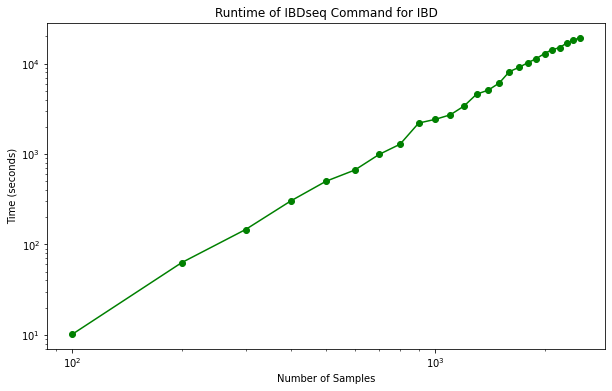

In [18]:
ibdseq_sizes_sorted = sorted(ibdseq_sizes, key = lambda x : x[0])
x3 = [item[0] for item in ibdseq_sizes_sorted]
y3 = [item[1][0] for item in ibdseq_sizes_sorted]

plt.figure(figsize=(10, 6))
plt.plot(x3, y3, marker = 'o', color="green")

plt.xlabel("Number of Samples")
plt.ylabel("Time (seconds)")
plt.title("Runtime of IBDseq Command for IBD")
plt.xscale('log')
plt.yscale('log')

### BEAGLE's fastIBD - Stress Testing

In [ ]:
if "fastibd" not in os.listdir("sizes"):
    os.mkdir("sizes/fastibd")
    
fastibd_sizes = []
for file in os.listdir("sizes/total_singular"):
    if "total_" in file:
        curr = file[:-4]
        print(curr)
        os.system("cat sizes/data/" + curr + ".vcf | java -jar vcf2beagle.jar ? sizes/data/" + curr)
        
        command = "java -jar beagle.jar unphased=sizes/data/" + curr + ".bgl.gz markers=sizes/data/" + curr + ".markers fastibd=true out=sizes/fastibd/" + curr + ".fastibd missing=?"
        times = run_time_mem(command)
        
        fastibd_sizes.append([int(curr[15:]),times])

### BEAGLE's fastIBD - Individual Analysis

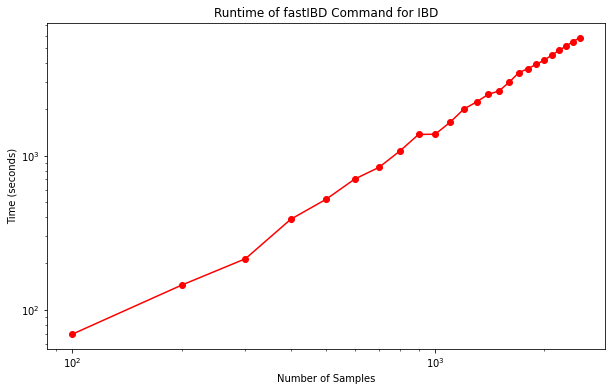

In [23]:
fastibd_sizes_sorted = sorted(fastibd_sizes, key = lambda x : x[0])
x4 = [item[0] for item in fastibd_sizes_sorted]
y4 = [item[1][0] for item in fastibd_sizes_sorted]

plt.figure(figsize=(10, 6))
plt.plot(x4, y4, marker = 'o', color="red")

plt.xlabel("Number of Samples")
plt.ylabel("Time (seconds)")
plt.title("Runtime of fastIBD Command for IBD")
plt.xscale('log')
plt.yscale('log')

### Subset Size Visualizations

In [28]:
persistent_p2 = [plink_sizes, germline_sizes, ibdseq_sizes, fastibd_sizes]

with open('persistent_p2.txt', 'w') as file:
    file.write(str(persistent_p2))

In [15]:
with open('persistent_p2.txt', 'r') as file:
    persistent_p2 = eval(file.read())

plink_sizes = persistent_p2[0]
germline_sizes = persistent_p2[1]
ibdseq_sizes = persistent_p2[2]
fastibd_sizes = persistent_p2[3]

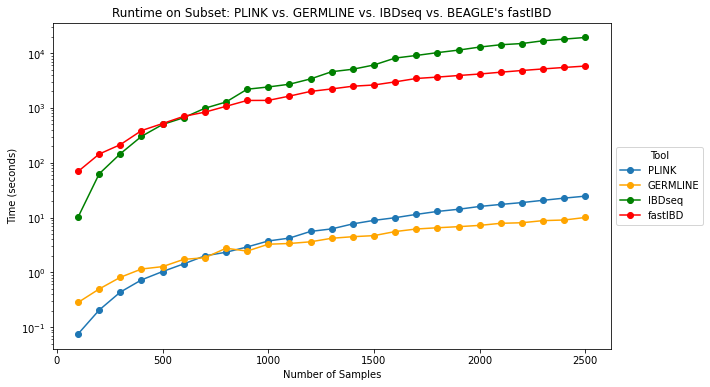

In [20]:
x = [item[0] for item in sorted(persistent_p2[0], key = lambda x : x[0])]
y1 = [item[1][0] for item in sorted(persistent_p2[0], key = lambda x : x[0])]
y2 = [item[1][0] for item in sorted(persistent_p2[1], key = lambda x : x[0])]
y3 = [item[1][0] for item in sorted(persistent_p2[2], key = lambda x : x[0])]
y4 = [item[1][0] for item in sorted(persistent_p2[3], key = lambda x : x[0])]

plt.figure(figsize=(10, 6))
plt.plot(x, y1, marker = 'o', label="PLINK")
plt.plot(x, y2, marker = 'o', label="GERMLINE", color="orange")
plt.plot(x, y3, marker = 'o', label="IBDseq", color="green")
plt.plot(x, y4, marker = 'o', label="fastIBD", color="red")

plt.xlabel("Number of Samples")
plt.ylabel("Time (seconds)")
plt.title('Runtime on Subset: PLINK vs. GERMLINE vs. IBDseq vs. BEAGLE\'s fastIBD')
plt.legend(title = "Tool", loc='center left', bbox_to_anchor=(1, 0.5))
plt.xscale('log')
plt.yscale('log')